# Factorization machine

## Giới thiệu

Nhắc lại nhược điểm lớn nhất của mô hình [matrix factorization](matrix_factorization.html) (MF) là nó không có khả năng mô hình hóa những thông tin bổ trợ về người dùng và sản phẩm. Một phương pháp mở rộng dựa trên matrix factorization là [factorization machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) (FM) có thể mô hình hóa được những thông tin bên lề mà mang lại sự cải thiện đáng kể. Phương pháp này cũng là nền móng có nhiều phương pháp liên quan đển Deep Learning cho bài toán gợi ý về sau. Trong mục này, chúng ta sẽ dẫn giải ý tưởng và triển khai mô hình cho bài toán gợi ý với bộ dữ liệu MovieLen-1M.

Trong MF, coi dữ liệu đầu vào là cặp (người dùng, sản phẩm) được biểu diễn bằng một vector $\mathbf{x} \in \mathbb{R}^{1\times d}$ chỉ có hai phần tử bằng một tương ứng với chỉ số của người dùng $i$ và sản phẩm $j$ đó như được biểu diễn ở hình dưới đây (ở đây sản phẩm là bộ phim). Hai ma trận embeddings của người dùng và sản phẩm cũng được ghép lại với nhau thành một ma trận $\mathbf{V} \in \mathbb{R}^{k\times d}$. Đồng thời, ta cũng ghép toàn bộ các hệ số tự do của người dùng và sản phẩm thành một vector $\mathbf{w} \in \mathbb{R}^{d \times 1}$ (không hiển thị trong hình). Khi đó, độ quan tâm của người dùng $i$ tới sản phẩm $j$ được viết lại thành:

$$
\hat{y}_{ij} = \mathbf{v}_i^T\mathbf{v}_j + w_i + w_j + w_0  (1)
$$

với $w_i$ là hệ số tự do ứng với người dùng $i$ thể hiện việc người này có “khó tính” hay không; $w_j$ là hệ số tự do ứng với sản phẩm $j$ thể hiện việc sản phẩm có phổ biến hay không; và hệ số tự do $w_0$ thể hiện thiên hướng chung của các đánh giá trong bộ dữ liệu.

Vì $x_i = x_j = 1$ và các thành phần còn lại của $\mathbf{x}$ bằng 0, ta có thể viết lại:

$$
\hat{y}_{ij} = w_0 + \mathbf{x}\mathbf{w} + \mathbf{v}_i^T\mathbf{v}_jx_i x_j  (2)
$$

Hai số hạng đầu tiên của vế phải chính là hồi quy tuyến tính, số hạng cuối cùng thể hiện sự tương tác giữa thành phần thứ $i$ (người dùng) với thành phần thứ $j$ (sản phẩm). Ta cần tìm các giá trị $w_0, \mathbf{w}, \mathbf{V}$ từ dữ liệu $\mathbf{x}$.

![](imgs/fm1.png)

Với bộ dữ liệu MovieLen-1M, ta còn có những thông tin liên quan về người dùng như giới tính, tuổi và nghề nghiệp. Với phim, ta cũng có thông tin về thể loại. Nếu tiếp tục chèn thêm vào $\mathbf{x}$ các thành phần liên quan đến giới tính (có chiều bằng 2), tuổi, nghề nghiệp và thể loại phim. Những thành phần này là các one-hot vector hoặc multi-hot vector (với thể loại phim) ứng với các dữ liệu dạng hạng mục và đều là những vector nhị phân có rất ít thành phần khác không. Nếu có thêm các dữ liệu dạng số khác, ta cũng có thể thêm vào $\mathbf{x}$ các phần tử tương ứng. Với dữ liệu dạng số, mỗi thành phần tương ứng với một thành phần trong $mathbf{x}$ và có thể là giá trị thực thay vì nhị phân. Với mỗi thành phần thêm vào $\mathbf{x}$, ta thêm một cột vector embeding vào $\mathbf{V}$.

![](imgs/fm2.png)

Lúc này, ngoài việc mô hình hóa sự tương tác giữa người dùng và bộ phim, ca cũng có thể mô hình hóa tương tác giữa người dùng và mỗi thể loại phim, hoặc nhóm tuổi với mỗi bộ phim, nhóm tuổi với thể loại phim. Sự tương tác giữa người dùng và nhóm tuổi hay nhóm tuổi với nghề nghiệp cũng được mô hình hóa. Tổng quát hơn, ta không cần quan tâm tới ý nghĩa của từng thành phân trong $\mathbf{x}$ mà có thể sử dụng tất cả các cặp hai thành phần khác nhau trong $\mathbf{x}$.

Khi đó, độ quan tâm của một người dùng tới một bộ phim có thể được xây dựng như sau:

$$
\hat{y} = w_0 + \mathbf{x}\mathbf{w} + \sum_{i = 1}^{d}\sum_{j=i+1}^d \mathbf{v}_i^T\mathbf{v}_j x_i x_j   (3)
$$

Đây chính là ý tưởng chính của FM. Biểu thức trên đây rất đẹp về mặt toán học như chứng mình ở dưới, đồng thời nhờ vào việc $\mathbf{x}$ thường là một vector rất thưa (rất ít thành phần khác 0), khiến cho việc huấn luyện và dự đoán trở nên rất nhanh ngay cả khi số lượng người dùng và sản phẩm lớn.

Biểu thức trên đây thể hiện mối quan hệ bậc hai giữa các thành phần của $\mathbf{x}$. FM có thể được mở rộng ra các bậc cao hơn, tuy nhiên các thí nghiệm thực tế cho thấy các bậc cao không mang lại kết quả tốt hơn nhiều trong khi lượng phép toán tăng lên đáng kể.

Cần phải nhấn mạnh thêm rằng, chỉ cần áp dụng các hàm mất mát phù hợp vào $\hat{y}$ trong (3) ta có thể áp dụng FM vào cả bài toán phân loại hoặc hồi quy.

## Huấn luyện mô hình

Tương tự như MF, việc huấn luyện các thành phần $w_0, \mathbf{w}$ và $\mathbf{V}$ cũng được thực hiện thông qua Gradient Descent. Việc tính toán với hai số hạng đầu tiên trong (3) tương đối hiển nhiên, số hạng cuối cần khéo léo một chút:

$$
\begin{align}
2\sum_{i = 1}^{d}\sum_{j=i+1}^d \mathbf{v}_i^T\mathbf{v}_j x_i x_j  
& = \Big(\sum_{i=1}^d \sum_{j=1}^d \mathbf{v}_i^T \mathbf{v}_j x_i x_j - \sum_{i=1}^d \mathbf{v}_i^T \mathbf{v}_i x_i x_i \Big) \\
& = \frac{1}{2}\Big(\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k v_{i, l}v_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k v_{i, l} v_{i, l} x_i x_i \Big) \\
& = \frac{1}{2}\sum_{l=1}^k \Big(\sum_{i=1}^d v_{i, l}x_i \sum_{j=1}^d v_{j, l} x_j - \sum_{i=1}^d \big(v_{i, l} x_i\big)^2 \Big) \\
& = \sum_{l=1}^k \Big(\big(\sum_{i=1}^d v_{i, l}x_i\big)^2 - \sum_{i=1}^d \big(v_{i, l} x_i\big)^2 \Big) \\
& = \sum_{l=1}^k \big(\sum_{i=1}^d v_{i, l}x_i\big)^2 - \sum_{l=1}^k \sum_{i=1}^d \big(v_{i, l} x_i\big)^2 \\
\end{align}
$$
với $v_{i, l}$ là thành phần ở cột thứ $i$ và hàng thứ $l$ của $\mathbf{V}$.

Cả hai thành phần trên đây đều có thể được tính nhanh chóng dựa vào các phép toán nhân ma trận và vector.

## Ví dụ với MovieLen-1M

### Tải và phân chia dữ liệu

Tương tự như trong MF, trước tiên ta tải và phân chia dữ liệu thành tập huấn luyện và tập kiểm thử.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# build dataset
import pytorch_lightning as pl
import torch
import torch.multiprocessing
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

import tabml.datasets


GLOBAL_SEED = 42  # number of life
torch.manual_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.multiprocessing.set_sharing_strategy('file_system')

df_dict = tabml.datasets.download_movielen_1m()
users, movies, ratings = df_dict["users"], df_dict["movies"], df_dict["ratings"]
ratings["Rating"] = ratings["Rating"] - 3  # rating range (-2, 2)
train_ratings, validation_ratings = train_test_split(
    ratings, test_size=0.1, random_state=42
)

In [2]:
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


### Chuẩn bị tập dữ liệu cho Pytorch


Ta sẽ sử dụng các thông tin sau cho người dùng và bộ phim:

* Với người dùng: chỉ số của 6040 người dùng, 2 giới tính, 7 nhóm tuổi và 21 nghề nghiệp. Tổng là 6070.
* Với bộ phim: chỉ số của 3883 bộ phim và 18 thể loại. Tổng là 3901.

Số chiều tương ứng với người dùng và bộ phim là khá lớn. Tuy nhiên ta không lưu toàn bộ vector này mà chỉ cần lưu mảng chứa vị trí của các phần tử bằng 1 ứng với các hạng mục tương ứng trong mỗi nhóm. Về sau, `nn.Embedding` sẽ giúp ta lấy ra các embedding tương ứng một cách nhanh chóng.


#### Xây dựng thông tin người dùng

Với mỗi người dùng, mã của họ được lưu ở `UserID`. Giới tính là `M` (Nam) hoặc `F` (Nữ). Tuổi được lưu dưới dạng tuổi thấp nhất trong các nhóm [1, 18), [18, 25), [25, 35), [35, 45), [45, 50), [50, 55), và 56 trở lên. Nghề nghiệp đã được lưu sẵn dưới dạng chỉ số từ 0 đến 20.

Mỗi người dùng sẽ được lưu bởi một mảng 4 giá trị [chỉ số người dùng, chỉ số giới tính, chỉ số nhóm tuổi, chỉ số nghề nghiệp]. Chỉ số người dùng là 1 trong 6040 giá trị đầu tiên từ 0 đến 6039, chỉ số giới tính là một trong hai giá trị 6040 (Nam) hoặc 6041 (Nữ) và tương tự với chỉ số nhóm tuổi và chỉ số nghề nghiệp.

In [3]:
# user_featuers
user_index_by_id = {id: idx for idx, id in enumerate(users["UserID"]) }
gender_index_by_name = {"M":0, "F": 1}
age_index_by_name = {1: 0, 18: 1, 25: 2, 35:3, 45: 4, 50: 5, 56:6}
occupations = [
"other",
"academic/educator",
"artist",
"clerical/admin",
"college/grad student",
"customer service",
"doctor/health care",
"executive/managerial",
"farmer",
"homemaker",
"K-12 student",
"lawyer",
"programmer",
"retired",
"sales/marketing",
"scientist",
"self-employed",
"technician/engineer",
"tradesman/craftsman",
"unemployed",
"writer",
]
occupation_index_by_name = {name: index for index, name in enumerate(occupations)}

num_users = len(users)
gender_offset = num_users
age_offset = gender_offset + len(gender_index_by_name)
occupation_offset = age_offset + len(age_index_by_name)

user_features = []
for index in range(num_users):
    gender_index = gender_index_by_name[users["Gender"][index]] + gender_offset
    age_index = age_index_by_name[users["Age"][index]] + age_offset
    occupation_index = users["Occupation"][index] + occupation_offset
    user_features.append([index, gender_index, age_index, occupation_index])
    
print("Example for the first user: ", user_features[0])

Example for the first user:  [0, 6041, 6042, 6059]


#### Xây dựng thông tin phim

Tương tự như vậy, mỗi bộ phim sẽ được lưu bởi một mảng mà giá trị đầu tiên là chỉ số của bộ phim, các giá trị tiếp theo là chỉ số của các thể loại. Lưu ý rằng các bộ phim có thể có số lượng thể loại khác nhau.

Vì sau này ta sẽ đặt thông tin bộ phim về phía sau thông tin người dùng, chỉ số của bộ phim sẽ bắt đầu từ 6070 (là kích thước vector người dùng).

In [4]:
# build moive_features

movie_index_by_id = {id: idx for idx, id in enumerate(movies["MovieID"])}
movie_offset = occupation_offset + len(occupation_index_by_name)

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
genre_index_by_name = {name:i for i, name in enumerate(genres)}
num_movies = len(movies)

movie_features = []
for i, movie_genres in enumerate(movies["Genres"]):
    movie_feature = [movie_offset + i]
    for genre in movie_genres.split("|"):
        genre_index = genre_index_by_name[genre] + num_movies + movie_offset
        movie_feature.append(genre_index)
    movie_features.append(movie_feature)
print("Example for the first movie:", movie_features[0])
total_inputs = movie_offset + num_movies + len(genres)
print(total_inputs)

Example for the first movie: [6070, 9955, 9956, 9957]
9971


#### Xây dựng `FactorizationMachineDataset`

Không giống như trong MF ở đó mỗi điểm dữ liệu được lưu dưới dạng `(user_id, movie_id, rating)`, với FM ta sẽ lưu một mảng chứa các chỉ số của các phần tử bằng một trong vector đặc trưng của người dùng và phim. Vì các mảng này có kích thước khác nhau, để có thể huấn luyện theo batch, ta cần *pad* thêm một lượng chỉ số phụ ở cuối sao cho các mảng có kích thước bằng nhau. Khi cập nhật trọng số, các thành phần tương ứng với chỉ số pad này sẽ không được cập nhật. (Đọc thêm về `padding_id` trong [torch.nn.Embdding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html))

In [5]:
from typing import List

import pandas as pd
import torch
from torch.utils.data import Dataset

NUM_MOVIES = len(movies)
NUM_USERS = len(users)
padding_idx = total_inputs


class FactorizationMachineDataset(Dataset):
    def __init__(self, rating_df):
        self.rating_df = rating_df
        self.max_size = 5 + len(genres)  # 4 for user feature + movie index + genres

    def __len__(self):
        return len(self.rating_df)

    def __getitem__(self, index):
        user_index = user_index_by_id[self.rating_df["UserID"].iloc[index]]
        movie_index = movie_index_by_id[self.rating_df["MovieID"].iloc[index]]
        rating = self.rating_df["Rating"].iloc[index]
        user_feature = user_features[user_index]
        movie_feature = movie_features[movie_index]
        padding_size = self.max_size - len(user_feature) - len(movie_feature)
        feature = user_feature + movie_feature + [padding_idx] * padding_size
        return torch.IntTensor(feature), rating


training_data = FactorizationMachineDataset(train_ratings)
validation_data = FactorizationMachineDataset(validation_ratings)

batch_size = 1024
num_workers = min(batch_size, 14)

train_dataloader = DataLoader(
    training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

validation_dataloader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

### Định nghĩa mô hình

Đoạn code dưới đây định nghĩa mô hình FM, ở đó các thuộc tính `bias, linear_layer, embedding` lần lượt là $w_0, \mathbf{w}$ và $\mathbf{V}$ trong biểu thức (3) (TODO: replace me by cross ref). Đầu ra của mô hình được cắt về khoảng (-2, 2) tương ứng với khoảng giá trị đánh giá (1 đến 5 sau khi chuẩn hóa bằng cách trừ 3).

In [6]:
from pytorch_lightning.loggers import TensorBoardLogger
import jdc

LR = 5e-4
WEIGHT_DECAY = 5e-5


class FactorizationMachine(pl.LightningModule):
    def __init__(self, num_inputs, num_factors):
        super(FactorizationMachine, self).__init__()
        self.embedding = nn.Embedding(num_inputs + 1, num_factors, padding_idx=padding_idx)
        self.embedding.weight.data.uniform_(-.1, .1)
        torch.nn.init.xavier_normal_(self.embedding.weight.data, gain=1e-3)
        self.linear_layer = nn.Embedding(num_inputs+1, 1, padding_idx=padding_idx)
        self.bias = nn.Parameter(data=torch.rand(1))
    

    def forward(self, x):
        emb = self.embedding(x)
        pow_of_sum = emb.sum(dim=1, keepdim=True).pow(2).sum(dim=2)
        sum_of_pow = emb.pow(2).sum(dim=1, keepdim=True).sum(dim=2)
        out_inter = 0.5 * (pow_of_sum - sum_of_pow)
        out_lin = self.linear_layer(x).sum(1)
        out = out_inter + out_lin + self.bias

        return torch.clip(out.squeeze(), min=-2, max=2)

In [7]:
%%add_to FactorizationMachine
def training_step(self, batch, batch_idx):
    inputs, rating = batch
    rating = rating.to(torch.float32)
    output = self.forward(inputs)
    loss = F.mse_loss(rating, output)
    self.log("batch_loss", loss)
    return {"loss": loss}


def validation_step(self, batch, batch_idx):
    inputs, rating = batch
    rating = rating.to(torch.float32)
    output = self.forward(inputs)
    loss = F.mse_loss(rating, output)
    self.log("batch_loss", loss)
    return {"loss": loss}


def training_epoch_end(self, outputs):
    avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
    self.logger.experiment.add_scalars(
        "RMSE", {"Train": avg_loss ** 0.5}, self.current_epoch
    )
    epoch_dict = {"loss": avg_loss}


def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
    self.logger.experiment.add_scalars(
        "RMSE", {"Val": avg_loss ** 0.5}, self.current_epoch
    )
    epoch_dict = {"loss": avg_loss}


def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    return optimizer

### Huấn luyện và đánh giá mô hình

In [8]:
n_factors = 100
logger = TensorBoardLogger(
    "fm_2_tb_logs", name=f"ilr{LR}_wd{WEIGHT_DECAY}_emb{n_factors}_b{batch_size}"
)

model = FactorizationMachine(num_inputs=total_inputs, num_factors=n_factors)
trainer = pl.Trainer(gpus=1, max_epochs=40, logger=logger)

trainer.fit(model, train_dataloader, validation_dataloader)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name         | Type      | Params
-------------------------------------------
0 | embedding    | Embedding | 997 K 
1 | linear_layer | Embedding | 10.0 K
-------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
def eval_model(model, train_dataloader):
    loss = 0
    for feature, rating in train_dataloader:
        pred = model(feature)
        loss += F.mse_loss(pred, rating)
    RMSE = (loss / len(train_dataloader))**.5
    return RMSE
    
print("Train RMSE: {:.3f}".format(eval_model(model, train_dataloader)))
print("Validation RMSE: {:.3f}".format(eval_model(model, validation_dataloader)))

Train RMSE: 0.790


Validation RMSE: 0.864


Kết quả thu được đã tốt hơn so với MF.


## Minh hoạ kết quả


Từ ma trận embedding thu được, chúng ta sẽ minh họa các bộ phim chỉ thuộc một thể loại trong số `Drama, Comedy` và `Horror`.

In [10]:
# find movies with single genres
embs_arr = model.state_dict()['embedding.weight'].detach().numpy()
movie_genres = movies["Genres"]
movie_inds_one_genre = [i for i, gs in enumerate(movie_genres) if gs in ('Drama', 'Comedy', 'Horror')]

movie_embs = embs_arr[movie_offset: movie_offset + num_movies, :]
movie_subset_embs = movie_embs[movie_inds_one_genre, :]

Embedding của những bộ phim này được minh họa trong không gian hai chiều sử dụng [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

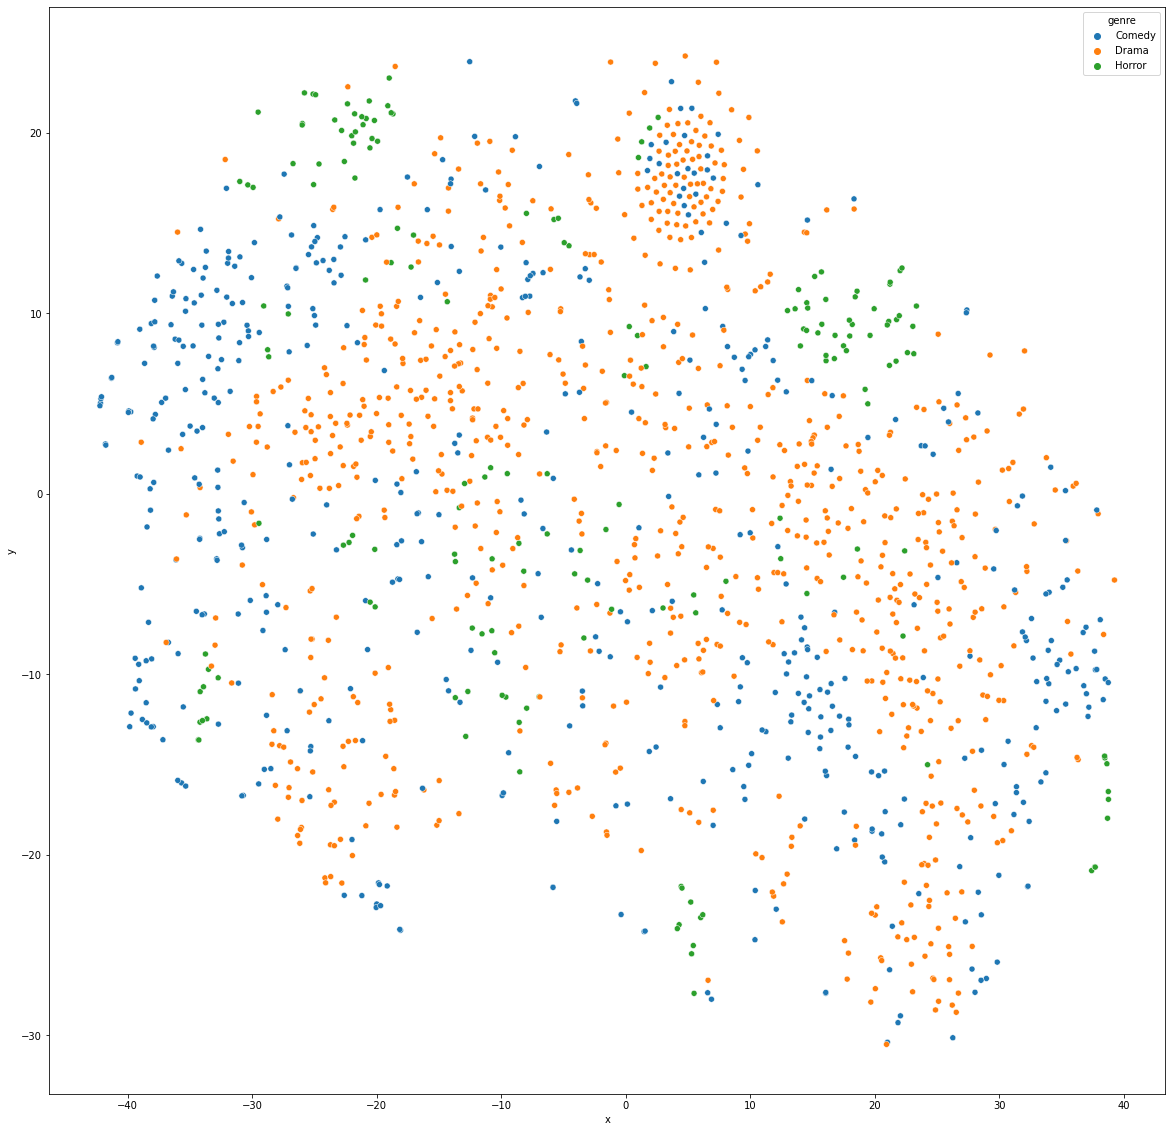

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

movie_subset_embs.shape
movie_2d = TSNE(n_components=2, init='pca').fit_transform(movie_subset_embs)
movie_df = pd.DataFrame(
    data={
        "x": movie_2d[:, 0],
        "y": movie_2d[:, 1],
        "genre": movie_genres[movie_inds_one_genre],
    }
)

plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="x", y="y", hue='genre',data=movie_df)

Mặc dù không thực sự rõ ràng, ta vẫn có thể thấy các bộ phim cùng thể loại (cùng màu) có xu hướng tập trung vào những khu vực gần nhau. Điều này chứng tỏ FM đã học được những thông tin hữu ích từ dữ liệu.

Bạn đọc có thể minh hoạc các nhóm embedding khác để tìm ra những điều thú vị khác của dữ liệu.

## Tóm tắt và thảo luận

* Factorization Machine là một phương pháp mở rộng của Matrix Factorization ở đó thông tin về sự tương tác giữa nhiều thành phần thông tin khác nhau được mô hình hóa dưới dạng một biểu thức bạc hai hoặc cao hơn. Thông thường, chỉ các tương tác bậc hai được sử dụng để giảm độ phức tạp tính toán.

* Ưu điểm nổi bật của nó so với MF là việc nó có thể tận dụng những thông tin bên lề về người dùng và sản phẩm để xây dựng mô hình. Ngoài ra, FM cũng giải quyết được vấn đề "khởi đầu lạnh" khi một người dùng hoặc sản phẩm chưa hề có tương tác nhưng đã có thông tin riêng về người dùng/sản phẩm đó.